# Food Image Classification

In [1]:
#Loading the Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import transform
import glob
import os
import random 

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, GlobalAveragePooling2D, Activation
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from keras import backend as K

Using TensorFlow backend.


### 1. Training the Model

Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.


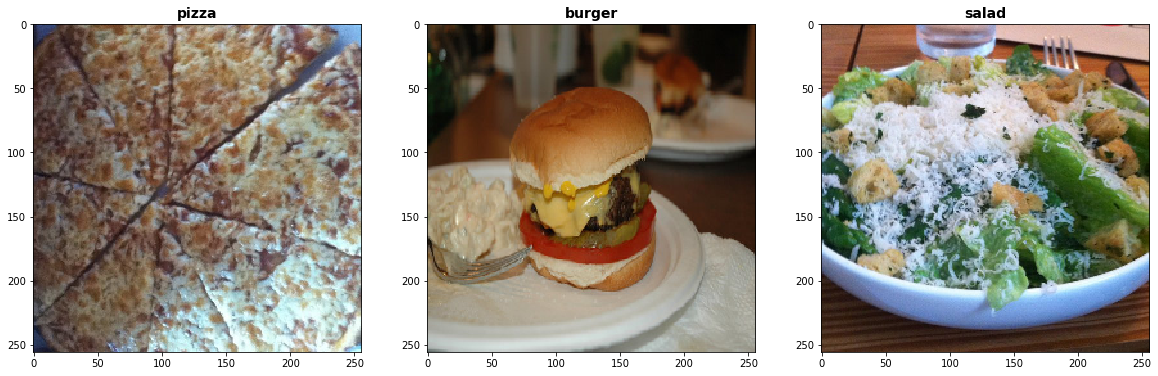

In [5]:
#Data Preprocessing
#The whole ETH Zürich's Food101 dataset can be found here: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/
#We have used 3 classified categories (burger,pizza,salad) a 1000 pictures and divided them into 750/250 pictures for training/testing. 
train_gen = ImageDataGenerator(rescale=1/255) #rescale 255 RGB to [0-1]
train_images = train_gen.flow_from_directory(
        "Data/food_images/train/",
        target_size=(256,256), #convert all images to same size
        batch_size=50)

test_gen = ImageDataGenerator(rescale=1/255) #rescale 255 RGB to [0-1]
test_images = test_gen.flow_from_directory(
        "Data/food_images/test/",
        target_size=(256,256), #convert all images to same size
        batch_size=50)

# sample view of training food images 
row = 1; col = 3
n=0
class_label = {'0':'burger','1':'pizza','2':'salad'}
for img in train_images:
    fig, axes = plt.subplots(row,col,figsize=(20,10))
    for x in range(col):
        axes[x].imshow(img[0][n])
        label = np.argmax(img[1],axis=1)[n]
        axes[x].set_title(class_label[str(label)],fontweight="bold", size=14)
        n+=1    
    break

In [10]:
#Setting up the Keras Model
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5), activation ='relu', input_shape = (256,256,3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5), activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 64, kernel_size = (3,3), activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3), activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 128, kernel_size = (3,3), activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3), activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 256, kernel_size = (3,3), activation ='relu'))
model.add(Conv2D(filters = 256, kernel_size = (3,3), activation ='relu'))
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(3, activation = "softmax",kernel_regularizer=l2()))

#Setting up callbacks (update model file name)
checkpointer = ModelCheckpoint(filepath='model_weights_3.hdf5', verbose=1, save_best_only=True, save_weights_only=True)

model.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

In [11]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 252, 252, 32)      2432      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 248, 248, 32)      25632     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 124, 124, 32)      0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 122, 122, 64)      18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 120, 120, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 60, 60, 64)       

In [12]:
#Training the model
e = 40 #For demo change to 2
history = model.fit_generator(train_images,steps_per_epoch=2250/50,
                              validation_data=test_images,validation_steps=750/50, callbacks= [checkpointer],
                              epochs=e)

Epoch 1/40
45/45 [==============================] - 1828s 41s/step - loss: 1.1392 - accuracy: 0.3089 - val_loss: 1.1200 - val_accuracy: 0.3333

Epoch 00001: val_loss improved from inf to 1.11996, saving model to Data/model_weights_5.hdf5
Epoch 2/40
45/45 [==============================] - 1787s 40s/step - loss: 1.1120 - accuracy: 0.3227 - val_loss: 1.1060 - val_accuracy: 0.3333

Epoch 00002: val_loss improved from 1.11996 to 1.10599, saving model to Data/model_weights_5.hdf5
Epoch 3/40
45/45 [==============================] - 1764s 39s/step - loss: 1.1033 - accuracy: 0.3333 - val_loss: 1.1013 - val_accuracy: 0.3333

Epoch 00003: val_loss improved from 1.10599 to 1.10133, saving model to Data/model_weights_5.hdf5
Epoch 4/40
45/45 [==============================] - 1795s 40s/step - loss: 1.1004 - accuracy: 0.3333 - val_loss: 1.0995 - val_accuracy: 0.3333

Epoch 00004: val_loss improved from 1.10133 to 1.09950, saving model to Data/model_weights_5.hdf5
Epoch 5/40
45/45 [==================

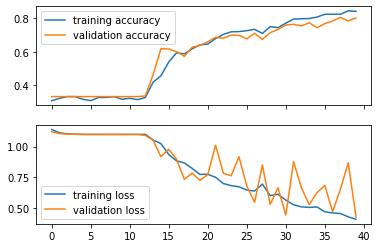

In [13]:
#Only run if model training has completed

#Show model training development 
hist = history.history

fig, ax = plt.subplots(2)

ax[0].plot(hist['accuracy'])
ax[0].plot(hist['val_accuracy'])
ax[0].legend(['training accuracy', 'validation accuracy'])

ax[1].plot(hist['loss'])
ax[1].plot(hist['val_loss'])
ax[1].legend(['training loss', 'validation loss'])

for axs in ax.flat:
    axs.label_outer()

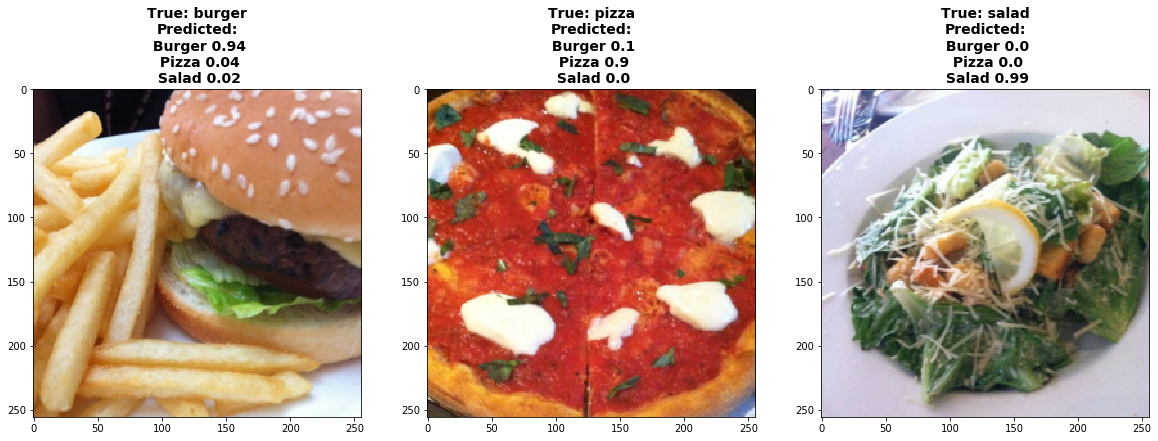

In [21]:
#Show 3 random predictions of test data
def load_image(filepath):
    np_image = Image.open(filepath)
    np_image = np.array(np_image).astype('float32')/255 #rescale to [0-1]
    np_image = transform.resize(np_image, (256, 256, 3)) #convert all images to same size
    np_image = np.expand_dims(np_image, axis=0)
    return np_image

burger_images = glob.glob("Data/food_images/test/burger/*.jpg")
pizza_images = glob.glob("Data/food_images/test/pizza/*.jpg")
salad_images = glob.glob("Data/food_images/test/salad/*.jpg")
images_paths = [burger_images,pizza_images,salad_images]

f, ax=plt.subplots(1,3,figsize=(20,10))
class_list = ["burger", "pizza", "salad"]

for i in range(3): 
    random_path = random.choice(images_paths[i])
    image = load_image(random_path)
    image_pred = model.predict(image)
    ax[i].imshow(image[0])
    ax[i].set_title("True: {}\nPredicted:\n Burger {}\n Pizza {}\n Salad {}".format(class_list[i],str(image_pred[0][0].round(decimals =2)),str(image_pred[0][1].round(decimals =2)),str(image_pred[0][2].round(decimals =2))),fontweight="bold", size=14)
    

### 2. Classifying the Yelp-Images

In [24]:
#Save model weights again (to make sure) 
#model.save_weights('model_weights_XX.hdf5')
#Load pre-trained model (alternativley)
#history = model.load_weights('model_weights_XX.hdf5')

In [19]:
#Load Yelp Data Sets
business_filt = pd.read_csv('Data/business_filtered_phx.csv') #Pre-Filtered dataset for Phoenix, AZ of restaurants that serve pizza,burger or salad
business_filt_id = business_filt["business_id"].to_list() #Extract all business id's
photos = pd.read_json("Data/yelp_dataset/photos.json", lines = True) #Read Yelp's photos info json with business-id, photo-id (=file name in directory), caption, label
photos_filt = photos.loc[photos['business_id'].isin(business_filt_id)] #Only keep the photos, which belong to restaurants in our pre-filtered list
photos_filt_img = photos_filt.loc[photos_filt['label'] == "food"] #Only keep photos label food (and not menu, interior etc)

#Move only pictures occuring in the filtered data set photos_filt_img to special folder (to reduce file size)
#for img in photos_filt_img["photo_id"].to_list():
#    os.rename('Data/yelp_dataset/yelp_photos/photos/{}.jpg'.format(img),'Data/food_images/yelp/{}.jpg'.format(img))

photos_directory = glob.glob("Data/yelp_dataset/photos/*.jpg") #List of all yelp photos' paths that appear in the photos_filt_img df

In [20]:
#Classify Yelp food images
image_class = pd.DataFrame(columns =["photo_id", "prob_burger", "prob_pizza", "prob_salad"]) 

i=0
for image_file in photos_directory: #iterate over each picture in the photos_directory and predict its class 
    image = load_image(image_file)
    image_pred = model.predict(image)
    image_name = image_file.replace("Data/yelp_dataset/photos/", "")
    image_class.loc[i] = [image_name.replace(".jpg", ""),image_pred[0][0],image_pred[0][1],image_pred[0][2]]
    i=i+1
    
image_class.head()

,photo_id,prob_burger,prob_pizza,prob_salad
0,_5epoM-0s54YOd7eGxkfxA,0.994254,0.001284,0.004462
1,N4AfuO5OsUqmW71na9Dlcw,0.982287,0.010888,0.006825
2,_MVu21O9HLdhFtP_5aM4-A,0.983369,0.000293,0.016338
3,DEXx9HwAwm3d1Y4knXhyFw,0.084963,0.001632,0.913405
4,cHSEPB3dSOyqVPg4OQpORw,0.765768,0.144962,0.089270


In [21]:
#Join and save the new classified photos information
photos_filt_img_class = pd.merge(image_class, photos_filt_img, on="photo_id") #join the classified images df with the original photos_filt_img info df 
photos_filt_img_class = photos_filt_img_class[["business_id" ,"photo_id" ,"prob_burger" ,"prob_salad" ,"prob_pizza" ,"caption" ,"label"]]
photos_filt_img_class.head()
print(photos_filt_img_class.shape)

photos_filt_img_class.to_json("Data/photos_filt_img_class_3.json") #update file number
photos_filt_img_class.to_csv("Data/photos_filt_img_class_3.csv") #update file number

#Save a new version of the filtered business list, only restaurants that have pictures
#business_filt = business.loc[business['business_id'].isin(photos_business_id)]
#business_filt.to_json("Data/business_filtered_phx_photos.json") #update file number
#business_filt.to_csv("Data/business_filtered_phx_photos.csv") #update file number

(2495, 7)
